In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])

f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
df = pd.read_csv(f, sep='\t')
df.sort_values(by='geneid.v').head()
df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
id_vars = ['tid', 'gid']
sample_columns = list(set(df.columns)-set(id_vars))

# remove transcripts that are wholly unexpressed
print(len(df.index))
df = df.loc[df[sample_columns].sum(axis=1)>0]
print(len(df.index))

# melt
print(df.shape)
df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                  var_name='sample', value_name='pi')
print(df.shape)

# add population info
df = df.merge(meta[['sample', 'population']], 
              how='left',
              on='sample')
df.head()

145107
129107
(129107, 45)
(5551601, 4)


,tid,gid,sample,pi,population
0,ENST00000010132.6,ENSG00000010219.14,YRI1,0.458975,YRI
1,ENST00000013894.3,ENSG00000011198.10,YRI1,0.000000,YRI
2,ENST00000075120.12,ENSG00000059804.18,YRI1,0.000832,YRI
3,ENST00000155093.8,ENSG00000067646.12,YRI1,0.000000,YRI
4,ENST00000167825.5,ENSG00000074964.17,YRI1,0.500000,YRI


In [4]:
129107*43

5551601

In [5]:
# gene expression / counts
f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
gene_df = pd.read_csv(f, sep='\t')
gene_df.head()
gene_df.sort_values(by='geneid.v').head()
gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
id_vars = ['gid']
sample_columns = list(set(gene_df.columns)-set(id_vars))
gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                  var_name='sample', value_name='g_counts')
df = df.merge(gene_df, 
              how='left',
              on=['gid', 'sample'])

## What do non-0 expression pi values look like?

Use to figure out what pseudocount to add

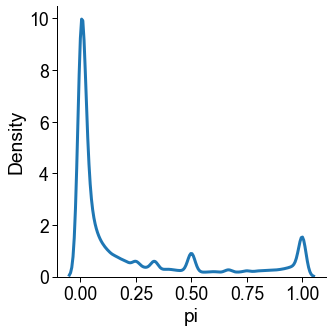

In [20]:
temp = df.loc[df.pi>0]

init_plot_settings(aspect='rectangle')
sns.displot(temp, kind='kde', x='pi', linewidth=3)

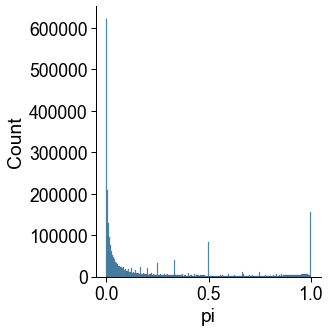

In [22]:
temp = df.loc[df.pi>0]

init_plot_settings(aspect='rectangle')
sns.displot(temp, x='pi')

In [23]:
temp.pi.min()

1.26081268670353e-13

In [36]:
print(len(temp.index))
print(len(temp.loc[temp.pi>0.005]))

# this looks like the first bar

2705544
2066658


## Apply pseudo count

In [7]:
pseudocount = 0.0025

df['pi_pseudo'] = df['pi']+pseudocount

## Compute unnormalized entropy

In [8]:
# groupby sample and gene to compute entropy 
# over pi values
e_df = df[['gid', 'sample',
          'pi_pseudo', 'population']].groupby(['gid', 'sample',
                                       'population']).apply(lambda x: st.entropy(x.pi_pseudo))
e_df = e_df.reset_index().rename({0:'entropy'}, axis=1)

## Compute normalized entropy

In [9]:
# get number of isoforms expressed per gene overall
n_t_df = df[['gid', 'tid']].groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
e_df = e_df.merge(n_t_df, how='left',
                  on='gid')

In [10]:
# normalize entropy values to max entropy values computed using 
# this stragtegy
# https://mc-stan.org/posterior/reference/entropy.html
e_df['norm_entropy'] = e_df.entropy/np.log(e_df.n_t)

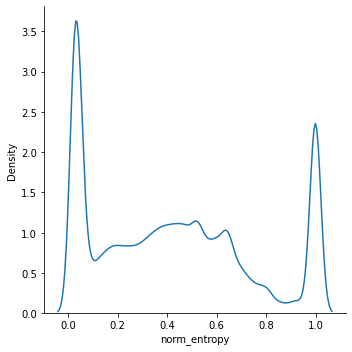

In [11]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='norm_entropy')

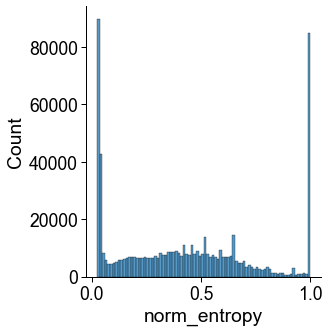

In [54]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='norm_entropy')
# peaks are probably at the different theoretical maxes maybe?

In [56]:
e_df.loc[e_df.norm_entropy>.8].head()

,gid,sample,population,entropy,n_t,norm_entropy
86,ENSG00000000460.17,AJI1,AJI,1.289005,4,0.929821
87,ENSG00000000460.17,AJI2,AJI,1.139938,4,0.822292
91,ENSG00000000460.17,AJI6,AJI,1.168193,4,0.842673
99,ENSG00000000460.17,HAC3,HAC,1.269625,4,0.915841
102,ENSG00000000460.17,HAC6,HAC,1.225424,4,0.883956


In [57]:
df.loc[(df.gid=='ENSG00000000460.17')&(df['sample']=='AJI1')]

,tid,gid,sample,pi,population,pi_pseudo
1407727,transcript_6675,ENSG00000000460.17,AJI1,0.392607,AJI,0.395107
1407729,transcript_6676,ENSG00000000460.17,AJI1,0.252177,AJI,0.254677
1407760,transcript_6684,ENSG00000000460.17,AJI1,0.261738,AJI,0.264238
1407773,transcript_6687,ENSG00000000460.17,AJI1,0.093478,AJI,0.095978


## First testing try -- unpaired wilcoxon

In [60]:
# first add European / non-Eur and African / OOA labels
e_df = e_df.merge(meta[['sample', 'ooa']],
                  how='left',
                  on='sample')

,gid,sample,population,entropy,n_t,norm_entropy,ooa
0,ENSG00000000419.14,AJI1,AJI,0.906423,24,0.285213,OOA
1,ENSG00000000419.14,AJI2,AJI,1.108997,24,0.348955,OOA
2,ENSG00000000419.14,AJI3,AJI,0.999648,24,0.314547,OOA
3,ENSG00000000419.14,AJI4,AJI,0.953054,24,0.299886,OOA
4,ENSG00000000419.14,AJI5,AJI,1.065029,24,0.335120,OOA


In [61]:
e_df['eu_non_eu'] = 'Non-European'
e_df.loc[e_df['population'].isin(['CEU', 'AJI']), 'eu_non_eu'] = 'European'

Wilcoxon rank-sum test statistic: 5.861813968409482
Wilcoxon rank-sum test pval: 2.2891889816079267e-09


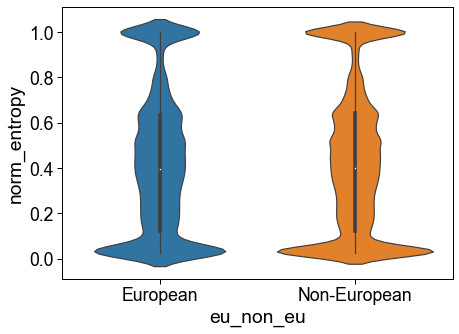

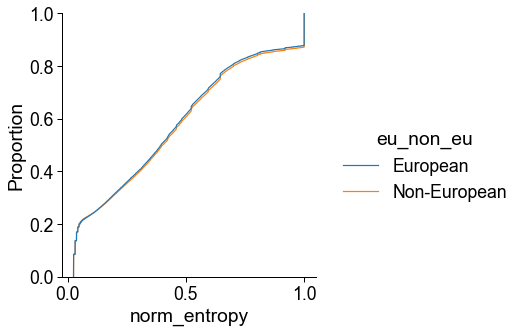

In [79]:
# European vs. non-European

sns.violinplot(e_df, x='eu_non_eu', y='norm_entropy')
sns.displot(e_df, hue='eu_non_eu', x='norm_entropy', kind='ecdf')


x = e_df.loc[e_df.eu_non_eu == 'Non-European', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = e_df.loc[e_df.eu_non_eu == 'European', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

Wilcoxon rank-sum test statistic: -1.548901096195833
Wilcoxon rank-sum test pval: 0.939297251299068


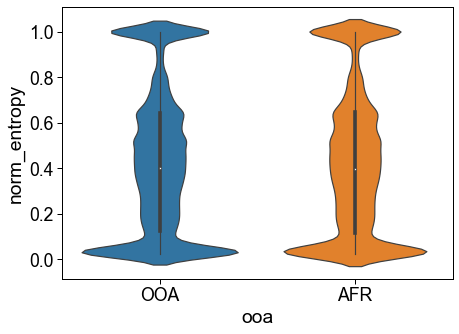

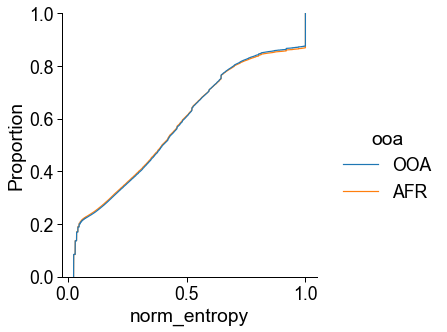

In [78]:
# African vs. OOA

sns.violinplot(e_df, x='ooa', y='norm_entropy')
sns.displot(e_df, hue='ooa', x='norm_entropy', kind='ecdf')


x = e_df.loc[e_df.ooa == 'AFR', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = e_df.loc[e_df.ooa == 'OOA', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

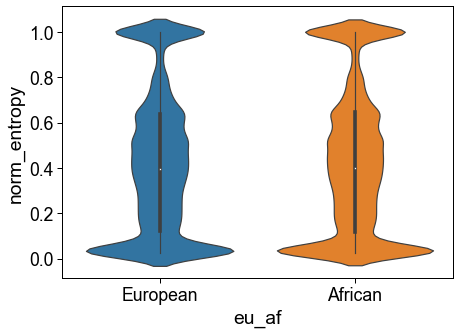

Wilcoxon rank-sum test statistic: 2.977659104671125
Wilcoxon rank-sum test pval: 0.0014522942252623646


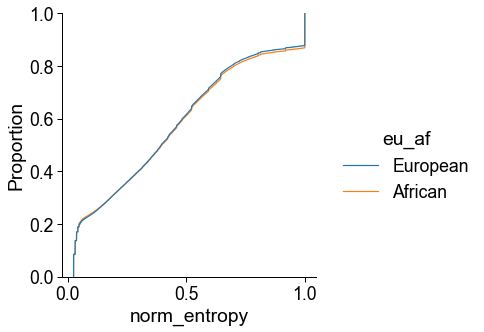

In [75]:
# African vs. Eur
temp = e_df.loc[(e_df.ooa=='AFR')|(e_df.eu_non_eu=='European')]
temp['eu_af'] = 'African'
temp.loc[temp.population.isin(['CEU', 'AJI']), 'eu_af'] = 'European'

sns.violinplot(temp, x='eu_af', y='norm_entropy')
plt.show()
sns.displot(temp, hue='eu_af', x='norm_entropy', kind='ecdf')

x = temp.loc[temp.eu_af == 'African', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp.loc[temp.eu_af == 'European', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

## Need to look more into filtering

## First, lets see how gene expression affects entropy distributions

In [12]:
drop_cols = [c for c in ['g_counts', 'log_g_counts', 'decile', 'cut_8', 'cut_10'] if c in e_df.columns]
e_df.drop(drop_cols, axis=1, inplace=True)

In [13]:
# log counts + 0.1
gene_df['log_g_counts'] = np.log(gene_df['g_counts']+1)

# add deciles to each gene / sample combination
_, bin_edges = pd.qcut(gene_df['log_g_counts'],
                       q=10, labels=False,
                       retbins=True,
                       duplicates='drop')

# You can assign deciles using these bin edges if needed
gene_df['decile'] = pd.cut(gene_df['log_g_counts'],
                           bins=bin_edges,
                           labels=False,
                           include_lowest=True)

# gene_df['decile'] = pd.qcut(gene_df['log_g_counts'],
#                             q=10, labels=False,
#                             duplicates='drop')

gene_df['cut_8'] = pd.cut(gene_df['log_g_counts'],
                            bins=8)

<AxesSubplot:xlabel='decile', ylabel='log_g_counts'>

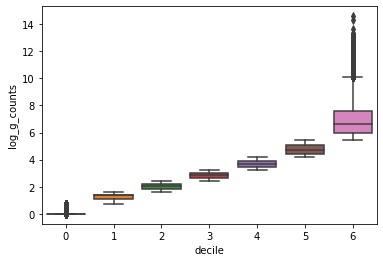

In [14]:
# look at gene counts per decile
sns.boxplot(gene_df, x='decile', y='log_g_counts')

<AxesSubplot:xlabel='cut_8', ylabel='log_g_counts'>

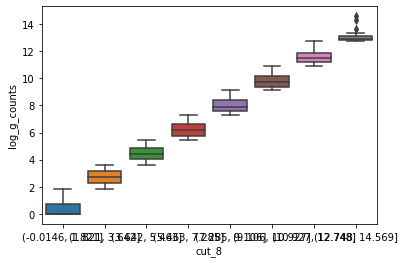

In [15]:
# look at gene counts per decile
sns.boxplot(gene_df, x='cut_8', y='log_g_counts')

In [16]:
e_df = e_df.merge(gene_df, 
                  how='left',
                  on=['sample', 'gid'])

<AxesSubplot:xlabel='decile', ylabel='norm_entropy'>

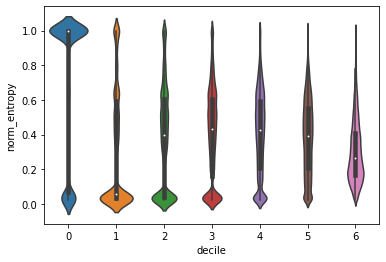

In [17]:
# plot entropy values by different gene expression deciles
# look at gene counts per decile
sns.violinplot(e_df, x='decile', y='norm_entropy')

In [18]:
gene_df[['decile', 'gid']].groupby('decile').nunique()

,gid
decile,
0,15564
1,14653
2,12397
3,10982
4,9708
5,7689
6,4875


<AxesSubplot:xlabel='cut_8', ylabel='norm_entropy'>

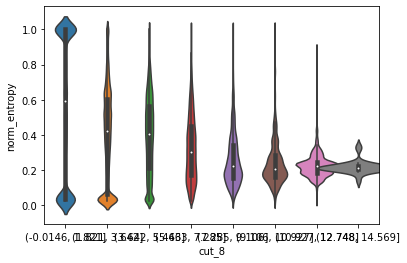

In [19]:
# plot entropy values by different gene expression deciles
# look at gene counts per decile
sns.violinplot(e_df, x='cut_8', y='norm_entropy', width=2)

In [20]:
gene_df[['cut_8', 'gid']].groupby('cut_8').nunique()

,gid
cut_8,
"(-0.0146, 1.821]",17755
"(1.821, 3.642]",14188
"(3.642, 5.463]",9476
"(5.463, 7.285]",4529
"(7.285, 9.106]",1501
"(9.106, 10.927]",443
"(10.927, 12.748]",113
"(12.748, 14.569]",12


## Retry wilcoxon unpaired tests

In [23]:
# lets remove things in the first decile then
print(len(e_df.index))
temp2 = e_df.loc[e_df.decile > 0]
print(len(temp2.index))

672649
559638


In [ ]:
# first add European / non-Eur and African / OOA labels
temp2 = temp2.merge(meta[['sample', 'ooa']],
                  how='left',
                  on='sample')

In [31]:
temp2.rename({'ooa_x':'ooa'}, axis=1, inplace=True)

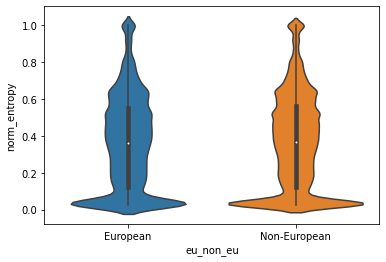

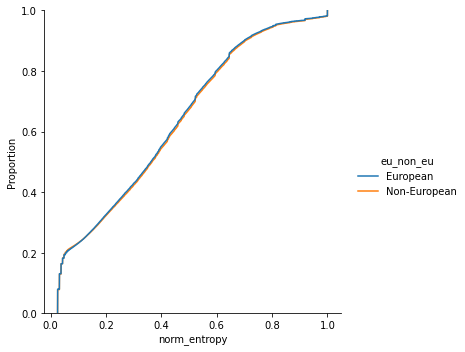

European vs. non-European
Wilcoxon rank-sum test statistic: 4.2270059773484325
Wilcoxon rank-sum test pval: 1.1841068945199712e-05


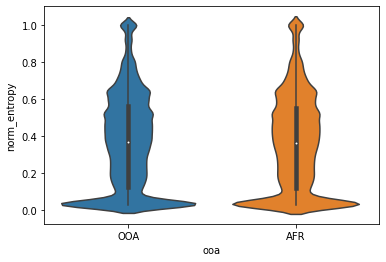

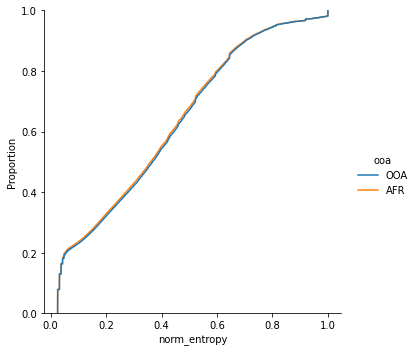

African vs. OOA
Wilcoxon rank-sum test statistic: -6.495915936757266
Wilcoxon rank-sum test pval: 0.9999999999587351


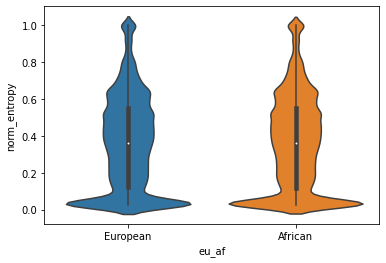

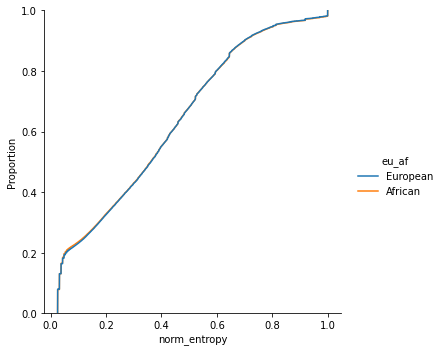

African vs. European
Wilcoxon rank-sum test statistic: -0.6680850247333315
Wilcoxon rank-sum test pval: 0.7479603398088817


In [32]:


temp2['eu_non_eu'] = 'Non-European'
temp2.loc[temp2['population'].isin(['CEU', 'AJI']), 'eu_non_eu'] = 'European'

# European vs. non-European

sns.violinplot(temp2, x='eu_non_eu', y='norm_entropy')
plt.show()
sns.displot(temp2, hue='eu_non_eu', x='norm_entropy', kind='ecdf')
plt.show()


x = temp2.loc[temp2.eu_non_eu == 'Non-European', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp2.loc[temp2.eu_non_eu == 'European', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print('European vs. non-European')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

# African vs. OOA

sns.violinplot(temp2, x='ooa', y='norm_entropy')
plt.show()
sns.displot(temp2, hue='ooa', x='norm_entropy', kind='ecdf')
plt.show()


x = temp2.loc[temp2.ooa == 'AFR', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp2.loc[temp2.ooa == 'OOA', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')
print('African vs. OOA')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

# African vs. Eur
temp = temp2.loc[(temp2.ooa=='AFR')|(temp2.eu_non_eu=='European')]
temp['eu_af'] = 'African'
temp.loc[temp.population.isin(['CEU', 'AJI']), 'eu_af'] = 'European'

sns.violinplot(temp, x='eu_af', y='norm_entropy')
plt.show()
sns.displot(temp, hue='eu_af', x='norm_entropy', kind='ecdf')
plt.show()

x = temp.loc[temp.eu_af == 'African', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp.loc[temp.eu_af == 'European', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')
print('African vs. European')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')